In [1]:
from Dataload import dataload
import torch.nn.functional as F

import torch
import torch.nn as nn
from torchsummary import summary
from sklearn.metrics import confusion_matrix
from torch.utils.data import Dataset, DataLoader
import matplotlib.pylab as plt
from torchvision import  utils

from src import detect_faces, show_bboxes
from PIL import Image
import numpy as np
from module import video_model
from constant import EMOTIPATH,EMOTIFACEPATH
import os
import pandas as pd
import time
from tqdm.notebook import tqdm
import cv2
from torchvision import transforms


In [2]:
from constant import AFFECTNETPATH

In [9]:
Train_label=os.path.join(EMOTIPATH,"Train_labels.txt")

Train_face=os.path.join(EMOTIFACEPATH,"Train")
Train_face_pt=os.path.join(EMOTIFACEPATH,"pt","Train")

Val_labels=os.path.join(EMOTIPATH,"Val_labels.txt")
Val_face=os.path.join(EMOTIFACEPATH,"Valid")
Val_face_pt=os.path.join(EMOTIFACEPATH,"pt","Valid")

In [83]:
class Face_Data(Dataset):
    def __init__(self,csv_file,face_path=None,direct=True):
        self.frame_num=25
        self.max_frame_num=25
        self._table = pd.read_csv(csv_file,delimiter=' ')
        self.transform=transforms.Compose([
                     transforms.ToTensor(),   
                     transforms.Normalize((0.5,0.5,0.5 ), (0.5, 0.5,0.5))])
        self.face_path=face_path

        self.direct=direct
        
    def _stacking_face(self,face_num,faces):

        face_v=torch.zeros((face_num,3,64,64))
        for i in range(face_num):
            face_v[i]=faces[:,:,i*64:i*64+64]
        return face_v
            
    def __getitem__(self, idx):
        folder_name = os.path.join(self.face_path,self._table.Vid_name[idx])
        if self.direct:
            
            face_path=folder_name
            
            frame_raw_list=os.listdir(folder_name)
            frame_len=len(frame_raw_list)
            frame_raw_list=sorted(frame_raw_list)
            frame_list=[]

            frame_index=(np.linspace(0,frame_len-1,self.frame_num,dtype=int))
            for index_2 in frame_index:
                frame_path=os.path.join(folder_name,frame_raw_list[index_2])
                face_pt=torch.load(frame_path)
                face_pt=self._stacking_face(5,face_pt)
                
                frame_list.append(face_pt)
            frame_data=torch.stack(frame_list,dim=0)
            
            
            
            
            
            return (frame_data,self._table.Vid_name[idx])
            
        else:
            
            
            frame_raw_list=os.listdir(folder_name)
            frame_len=len(frame_raw_list)

            frame_raw_list=sorted(frame_raw_list)
               # print(frame_raw_list)
            frame_list=[]

            frame_index=(np.linspace(0,frame_len-1,self.frame_num,dtype=int))
            for index_2 in frame_index:
                frame_path=os.path.join(folder_name,frame_raw_list[index_2])
                tempimg=Image.open(frame_path)
                tempimg=self.transform(tempimg)
                tempimg=self._stacking_face(5,tempimg)
                frame_list.append(tempimg)
                
            while(len(frame_list)<self.frame_num):
                frame_list.append(self.endPad)
            frame_data=torch.stack(frame_list,dim=0)

            return (frame_data,self._table.Vid_name[idx])
        

In [98]:
train_data=Face_Data(Train_label,Train_face,direct=False)
valid_data=Face_Data(Val_labels,Val_face,direct=False)

In [93]:
savepath=os.path.join(EMOTIFACEPATH,"pt_stacked")
if not os.path.isdir(savepath):
    os.mkdir(savepath)

In [96]:
train_save_path=os.path.join(savepath,"Train")
valid_save_path=os.path.join(savepath,"Valid")
if not os.path.isdir(train_save_path):
    os.mkdir(train_save_path)
if not os.path.isdir(valid_save_path):
    os.mkdir(valid_save_path)

In [101]:
valid_data[0][0].shape

torch.Size([25, 5, 3, 64, 64])

In [105]:
for data in tqdm(train_data):
    filename=data[1]+".pt"
    torch.save(data[0],os.path.join(train_save_path,filename))



KeyError: 2661

In [67]:
dataset[0][1]

'2_1'

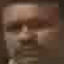

In [64]:
trans=transforms.ToPILImage()
trans(dataset[0][0][22][0]*0.5+0.5)

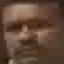

In [65]:
trans(dataset1[0][0][22][0]*0.5+0.5)

In [48]:
np.where(dataset[0][0]!=dataset1[0][0])

(array([ 0,  0,  0, ..., 24, 24, 24]),
 array([0, 0, 0, ..., 2, 2, 2]),
 array([ 0,  0,  0, ..., 63, 63, 63]),
 array([  0,   1,   5, ..., 189, 190, 191]))

In [ ]:
class Raw_Data():
    def __init__(self,csv_file,base_path_v=None,):
        
        self.max_frame_num=24
        self._table = pd.read_csv(csv_file,delimiter=' ')

        self._base_path_v=base_path_v
  

            

        self.transform=transforms.Compose([
                     transforms.Resize((256,256)),
                     transforms.ToTensor(),   
                     transforms.Normalize((0.5,0.5,0.5 ), (0.5, 0.5,0.5))])
    def __len__(self):
        return len(self._table)

    def __getitem__(self, idx):
        folder_name = os.path.join(self._base_path_v,self._table.Vid_name[idx])
        frame_list=os.listdir(folder_name)


        return folder_name,frame_list

In [ ]:
train_data[566]

In [ ]:
from operator import itemgetter, attrgetter

In [ ]:
def extract_best(num_frame,data):

for index,(base_path,imglist) in enumerate(train_data):
    confidence_score_list=[]
    for img_frame in imglist:
        
        img=Image.open(os.path.join(base_path,img_frame))
        total_confidence_score=sum(detect_faces(img)[0][0:5,-1])
        confidence_score_list.append((total_confidence_score,img_frame))
    confidence_score_list=sorted(confidence_score_list, key=itemgetter(0),reverse=True)
    sorted(confidence_score_list[0:num_frame]
    break


In [ ]:
confidence_score_list[0:5]

In [ ]:
confidence_score_list=sorted(confidence_score_list, key=itemgetter(0),reverse=True)

In [ ]:
confidence_score_list[0:5]

In [ ]:
sorted(confidence_score_list[0:5],key=itemgetter(0))

In [ ]:
img=Image.open(os.path.join(train_data[0][0],train_data[0][1][1]))

In [ ]:
img

In [ ]:
confidence_score=sum(detect_faces(img)[0][0:5,-1])

In [ ]:
sum(confidence_score)

In [ ]:
faces[0][0:5,-1]

In [ ]:
    
class cv_data(Dataset):
    def __init__(self,csv_file,sub_csv_file=None,
                 base_path_v=None,base_path_a=None,frame_num=16,strict_name=True,name_format=9,embedding=False):
        
        self.max_frame_num=24
        self._table = pd.read_csv(csv_file,delimiter=' ')
        if sub_csv_file is None:
            self._table_embedding=None
        else:
            self._table_embedding=pd.read_csv(sub_csv_file)
        self.frame_num = frame_num
        self._base_path_v=base_path_v
        self._base_path_a=base_path_a
        self.embedding=embedding
        if strict_name:
            self.name_format=name_format
            

        self.transform=transforms.Compose([
                     transforms.ToTensor(),   
                     transforms.Normalize((0.5,0.5,0.5 ), (0.5, 0.5,0.5))])
    def __len__(self):
        return len(self._table)

    def __getitem__(self, idx):
        folder_name = os.path.join(self._base_path_v,self._table.Vid_name[idx])
        first=True
        audio_img=np.zeros((1,1))
        labels = torch.from_numpy(np.array(self._table.Label[idx]))-1
            
        if self._table_embedding is not None:
            temp_frame_embedding=torch.from_numpy(np.array(self._table_embedding.Embedding[idx].split(),dtype=float)).reshape((self.max_frame_num,-1))
            frame_data=torch.empty(size=(self.frame_num,1000),dtype=torch.double)
            if self.frame_num<self.max_frame_num:
                index=np.linspace(0,self.max_frame_num-1,self.frame_num,dtype=int)
 
                for i,copy in enumerate(index):
                    frame_data[i]=temp_frame_embedding[copy]
            return (frame_data,audio_img,labels)
    

            
        frame_raw_list=os.listdir(folder_name)
        frame_len=len(frame_raw_list)

        frame_raw_list=sorted(frame_raw_list)

        frame_list=[]
        if frame_len<self.frame_num:
            for index_0 in range(frame_len):
                frame_path=os.path.join(folder_name,frame_raw_list[index_0])
                
                tempimg=cv2.imread(frame_path,cv2.IMREAD_COLOR)  
                tempimg=cv2.resize(tempimg, (256,256), interpolation = cv2.INTER_AREA)
               # frame_class=frame(tempimg,frame_path)
                frame_list.append(self.transform(tempimg))
        else:    
            frame_index=(np.linspace(0,frame_len-1,self.frame_num,dtype=int))
            for index_2 in frame_index:
                frame_path=os.path.join(folder_name,frame_raw_list[index_2])
                tempimg=cv2.imread(frame_path,cv2.IMREAD_COLOR)
                tempimg=cv2.resize(tempimg, (256,256), interpolation = cv2.INTER_AREA)

                #frame_class=frame(tempimg,frame_path)
                frame_list.append(self.transform(tempimg))
        frame_data=torch.stack(frame_list,dim=0)
        return (frame_data,audio_img,labels)

In [ ]:
    
class pil_data(Dataset):
    def __init__(self,csv_file,sub_csv_file=None,
                 base_path_v=None,base_path_a=None,frame_num=16,strict_name=True,name_format=9,embedding=False):
        
        self.max_frame_num=24
        self._table = pd.read_csv(csv_file,delimiter=' ')
        if sub_csv_file is None:
            self._table_embedding=None
        else:
            self._table_embedding=pd.read_csv(sub_csv_file)
        self.frame_num = frame_num
        self._base_path_v=base_path_v
        self._base_path_a=base_path_a
        self.embedding=embedding
        if strict_name:
            self.name_format=name_format
            

        self.transform=transforms.Compose([
                     transforms.Resize((256,256)),
                     transforms.ToTensor(),   
                     transforms.Normalize((0.5,0.5,0.5 ), (0.5, 0.5,0.5))])
    def __len__(self):
        return len(self._table)

    def __getitem__(self, idx):
        folder_name = os.path.join(self._base_path_v,self._table.Vid_name[idx])
        first=True
        audio_img=np.zeros((1,1))
        labels = torch.from_numpy(np.array(self._table.Label[idx]))-1
            
        if self._table_embedding is not None:
            temp_frame_embedding=torch.from_numpy(np.array(self._table_embedding.Embedding[idx].split(),dtype=float)).reshape((self.max_frame_num,-1))
            frame_data=torch.empty(size=(self.frame_num,1000),dtype=torch.double)
            if self.frame_num<25:
                index=np.linspace(0,23,self.frame_num,dtype=int)
 
                for i,copy in enumerate(index):
                    frame_data[i]=temp_frame_embedding[copy]
            return (frame_data,audio_img,labels)
    
        
            
        frame_raw_list=os.listdir(folder_name)
        frame_len=len(frame_raw_list)

        frame_raw_list=sorted(frame_raw_list)

        frame_list=[]
        if frame_len<self.frame_num:
            for index_0 in range(frame_len):
                frame_path=os.path.join(folder_name,frame_raw_list[index_0])
                
                tempimg=Image.open(frame_path)       
               # frame_class=frame(tempimg,frame_path)
                frame_list.append(self.transform(tempimg))
        else:    
            frame_index=(np.linspace(0,frame_len-1,self.frame_num,dtype=int))

            for index_2 in frame_index:
                frame_path=os.path.join(folder_name,frame_raw_list[index_2])
                tempimg=Image.open(frame_path)
                #frame_class=frame(tempimg,frame_path)
                frame_list.append(self.transform(tempimg))
        frame_data=torch.stack(frame_list,dim=0)
        return (frame_data,audio_img,labels)

In [ ]:
Train_label=os.path.join(EMOTIPATH,"Train_labels.txt")
Train_video=os.path.join(EMOTIPATH,"Train")
Val_labels=os.path.join(EMOTIPATH,"Val_labels.txt")
Val_video=os.path.join(EMOTIPATH,"Val")
train_data_pil=pil_data(Train_label,base_path_v=Train_video,frame_num=24)
train_dataloader_pil = DataLoader(train_data_pil, batch_size=16
                       , num_workers=0,shuffle=False)                    
                    

In [ ]:
train_data_cv=cv_data(Train_label,base_path_v=Train_video,frame_num=24)
train_dataloader_cv = DataLoader(train_data_cv, batch_size=16
                       , num_workers=0,shuffle=False)       

In [ ]:
start=time.time()
for i in enumerate(train_dataloader_pil):
    break

end=time.time()
print(end-start)

In [ ]:
start=time.time()
for i in enumerate(train_dataloader_cv):
    break

end=time.time()
print(end-start)

In [ ]:
class Frame_Face_Data(Dataset):
    def __init__(self,csv_file,sub_csv_file=None,base_path_v=None):
        
        self.max_frame_num=5
        self._table = pd.read_csv(csv_file,delimiter=' ')
        self._table_embedding=None
        self.transform=transforms.Compose([
                 #    transforms.Resize((256,256)),
                     transforms.ToTensor(),   
                    transforms.Normalize((0.5,0.5,0.5 ), (0.5, 0.5,0.5))
        ])
        self.endPad=self.transform(Image.new(mode='RGB', size=(64,64), color=0))
        self._base_path_v=base_path_v
        
    def __len__(self):
        return len(self._table)
    def _stacking_face(self,face_num,faces):

        face_v=torch.zeros((face_num,3,64,64))
        for i in range(face_num):
            face_v[i]=faces[:,:,i*64:i*64+64]
        return face_v

    def __getitem__(self, idx):
        folder_name = os.path.join(self._base_path_v,self._table.Vid_name[idx])

        labels = torch.from_numpy(np.array(self._table.Label[idx]))-1
            
        if self._table_embedding is not None:
            temp_frame_embedding=torch.from_numpy(np.array(self._table_embedding.Embedding[idx].split(),dtype=float)).reshape((self.max_frame_num,-1))
            frame_data=torch.empty(size=(self.frame_num,1000),dtype=torch.double)
            if self.frame_num<25:
                index=np.linspace(0,23,self.frame_num,dtype=int)
 
                for i,copy in enumerate(index):
                    frame_data[i]=temp_frame_embedding[copy]
            return (frame_data,audio_img,labels)
    

        face_len=5
        face_raw_list=os.listdir(folder_name)
        face_raw_list=sorted(face_raw_list)

        face_list=[]
        for index_0 in range(face_len):
                face_path=os.path.join(folder_name,face_raw_list[index_0])               
                tempimg=Image.open(face_path)       
                face_list.append(self._stacking_face(face_len,self.transform(tempimg)))
            

        face_data=torch.stack(face_list,dim=0)
            
        return (face_data)

In [ ]:
Train_label=os.path.join(EMOTIPATH,"Train_labels.txt")
Train_face=os.path.join(EMOTIPATH,"Face_Cropped","Train")
Val_labels=os.path.join(EMOTIPATH,"Val_labels.txt")
Val_face=os.path.join(EMOTIPATH,"Face_Cropped","Val")

In [ ]:
test=Frame_Face_Data(Train_label,Train_face,base_path_v=Train_face)

In [ ]:
test[0].shape

In [ ]:
trans = transforms.ToPILImage()

In [ ]:
data=test[0][0]*0.5+0.5

In [ ]:
data.shape

In [ ]:
def stacking_face(face_num,faces):

    face_v=torch.zeros((face_num,3,64,64))
    for i in range(face_num):
        face_v[i]=faces[:,:,i*64:i*64+64]
    return face_v


In [ ]:
for i in range(5):
    
    plt.subplot(5,1,i+1)
    plt.imshow((trans((face_v[i]).squeeze(0))))

In [ ]:
face_v[4].shape